# CLASSIFICATION

Tipos de problemas de clasificación

- Binaria
    - Se debe clasificar entre 2 clases (ejemplo: es un perro o un gato)

- Multiclase
    - Se debe clasfificar entre múltiples clases (ejemplo: es un dígito entre el 0 y el 9)

- Multi-output
    - Cada ejemplo puede tener más de 1 etiqueta (ejemplo: en una imagen hay un auto, un árbol y una persona; cualquier combinación de ellos)


## Binary Classification

Recomendaciones en la elección de los hiperparámetros



----> tabla!!!!!




In [4]:
#https://www.kaggle.com/code/ryanholbrook/binary-classification
#https://www.kaggle.com/code/marcosnicolsgarca/exercise-binary-classification/edit

In [2]:
import pandas as pd

In [29]:

hotel = pd.read_csv('data/BookingCancellation.csv')

hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01/07/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01/07/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,02/07/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,02/07/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,03/07/2015


In [30]:
hotel.shape

(119390, 32)

In [31]:
hotel.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [28]:




"""

# preprocess,

# nulos; var. categóricas.....


#for h in hotel.columns:
#    print(hotel[h].dtype)


#any(palabra in hotel for palabra in palabras_a_verificar)
#hotel[h].dtype=='int64']


palabras_a_verificar = ['int','float']

features_num = [h for h in hotel.columns if any(palabra in str(hotel[h].dtype) for palabra in palabras_a_verificar)]

print(features_num)




['is_canceled', 'lead_time', 
 'arrival_date_year', 
 'arrival_date_week_number', 
 'arrival_date_day_of_month', 
 'stays_in_weekend_nights', 
 'stays_in_week_nights', 
 'adults', 
 'children', 'babies', 'is_repeated_guest', 
 'previous_cancellations', 
 'previous_bookings_not_canceled', 
 'booking_changes', 'agent', 
 'company', 
 'days_in_waiting_list', 'adr', 
 'required_car_parking_spaces', 
 'total_of_special_requests']


features_num2 = [
    "lead_time", 
    "arrival_date_week_number",
    "arrival_date_day_of_month", 
    "stays_in_weekend_nights",
    "stays_in_week_nights", 
    "adults", "children", 
    "babies",
    "is_repeated_guest", 
    "previous_cancellations",
    "previous_bookings_not_canceled", 
    "required_car_parking_spaces",
    "total_of_special_requests", 
    "adr",
]





print(len(features_num ))



print(len(features_num2 ))



columnas_numericas = hotel.select_dtypes(include=['int', 'float'])
list(columnas_numericas.columns)


print(len(columnas_numericas.columns))


"""


'\n\n# preprocess,\n\n# nulos; var. categóricas.....\n\n\n#for h in hotel.columns:\n#    print(hotel[h].dtype)\n\n\n#any(palabra in hotel for palabra in palabras_a_verificar)\n#hotel[h].dtype==\'int64\']\n\n\npalabras_a_verificar = [\'int\',\'float\']\n\nfeatures_num = [h for h in hotel.columns if any(palabra in str(hotel[h].dtype) for palabra in palabras_a_verificar)]\n\nprint(features_num)\n\n\n\n\n[\'is_canceled\', \'lead_time\', \n \'arrival_date_year\', \n \'arrival_date_week_number\', \n \'arrival_date_day_of_month\', \n \'stays_in_weekend_nights\', \n \'stays_in_week_nights\', \n \'adults\', \n \'children\', \'babies\', \'is_repeated_guest\', \n \'previous_cancellations\', \n \'previous_bookings_not_canceled\', \n \'booking_changes\', \'agent\', \n \'company\', \n \'days_in_waiting_list\', \'adr\', \n \'required_car_parking_spaces\', \n \'total_of_special_requests\']\n\n\nfeatures_num2 = [\n    "lead_time", \n    "arrival_date_week_number",\n    "arrival_date_day_of_month", \n  

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )


# vars. numéricas
features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]

# vars. catg.
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]



# SimpleImputer remplaza los valores faltantes

# StandardScaler -> Standardize features by removing the mean and scaling to unit variance.



# transfomer para las variables numéricas

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)



# transformer para las categóricas
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)



# make_column_:transfoerm -> Construct a ColumnTransformer from the given transformers.

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)



# train test split



# stratify - make sure classes are evenlly represented across splits
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]


# TIENE MAYOR TAMAÑO POR EL ONE-HOT ENCODING!! (63 en vez de 32)






In [35]:
X_train.shape

(89542, 63)

In [36]:
from tensorflow import keras
from tensorflow.keras import layers



2023-11-14 19:19:12.812749: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 19:19:13.238214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 19:19:13.239372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 19:19:14.709221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [37]:
# primer modelo, bien sencillo

simple_model = keras.Sequential([
    layers.Dense(20,activation='relu',input_shape=input_shape),
    layers.Dense(20,activation='relu'),
    layers.Dense(20,activation='relu'),
    layers.Dense(1,activation='sigmoid'),
])



simple_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )


history1 = simple_model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    batch_size=512,
    epochs=20,
    callbacks=[early_stopping]
)





Epoch 1/20


2023-11-14 19:26:38.734279: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22564584 exceeds 10% of free system memory.


175/175 [==============================] - 1s 3ms/step - loss: 0.5041 - accuracy: 0.7641 - val_loss: 0.4339 - val_accuracy: 0.8050
Epoch 2/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4199 - accuracy: 0.8100 - val_loss: 0.4184 - val_accuracy: 0.8107
Epoch 3/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4079 - accuracy: 0.8131 - val_loss: 0.4089 - val_accuracy: 0.8134
Epoch 4/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4023 - accuracy: 0.8136 - val_loss: 0.4041 - val_accuracy: 0.8133
Epoch 5/20
175/175 [==============================] - 0s 2ms/step - loss: 0.3971 - accuracy: 0.8148 - val_loss: 0.4001 - val_accuracy: 0.8159
Epoch 6/20
175/175 [==============================] - 0s 2ms/step - loss: 0.3932 - accuracy: 0.8160 - val_loss: 0.3978 - val_accuracy: 0.8147
Epoch 7/20
175/175 [==============================] - 0s 2ms/step - loss: 0.3902 - accuracy: 0.8174 - val_loss: 0.3955 - val_accuracy: 0.8151
Epoch 8/20
175/17

In [48]:
history_df1 = pd.DataFrame(history1.history)


history_df1.head()



,loss,accuracy,val_loss,val_accuracy
0,0.504124,0.764077,0.433915,0.805046
1,0.419948,0.809955,0.418434,0.810708
2,0.407901,0.813116,0.408924,0.813354
3,0.402272,0.813585,0.404130,0.813254
4,0.397070,0.814847,0.400065,0.815934


<AxesSubplot:>

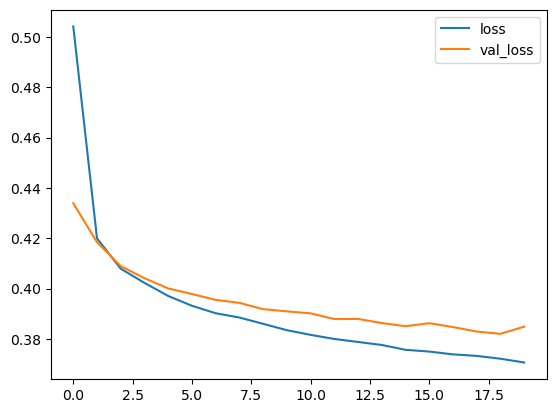

In [46]:
# Start the plot at epoch 5
history_df1.loc[:, ['loss', 'val_loss']].plot()

In [49]:
# matriz de confusión

In [55]:
import numpy as np

In [53]:
import tensorflow as tf

In [57]:
import matplotlib.pyplot as plt

933/933 [==============================] - 1s 677us/step


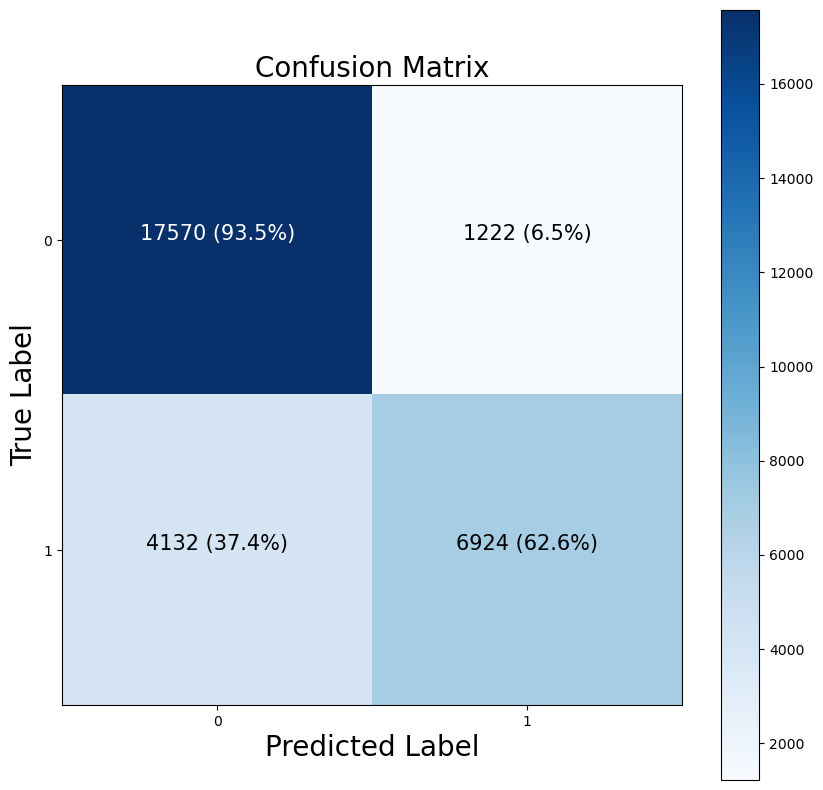

In [58]:

from sklearn.metrics import confusion_matrix


y_preds = simple_model.predict(X_test)



import itertools

figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(y_test, tf.round(y_preds))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize our confusion matrix
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
   xlabel="Predicted Label",
   ylabel="True Label",
   xticks=np.arange(n_classes),
   yticks=np.arange(n_classes),
   xticklabels=labels,
   yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
       horizontalalignment="center",
       color="white" if cm[i, j] > threshold else "black",
       size=15)

no anda muy bieN, el mayor problema son los falsos negativos

In [61]:
simple_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1280      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,141
Trainable params: 2,141
Non-trainable params: 0
_________________________________________________________________


In [63]:
simple_model.evaluate(X_test,y_test,verbose=2)

933/933 - 1s - loss: 0.3849 - accuracy: 0.8206 - 623ms/epoch - 668us/step


[0.3848715126514435, 0.8206244707107544]

## segundo modelo

In [69]:


model2 = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(256,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(256,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(1,activation='sigmoid')
])


model2.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)



early_stopping = keras.callbacks.EarlyStopping(
        patience=20,
        min_delta=0.001,
        restore_best_weights=True,
    )



history2 = model2.fit(
        X_train,y_train,
        validation_data=(X_test,y_test),
        batch_size=512,
        epochs=40,
        callbacks=[early_stopping]
)

Epoch 1/40


2023-11-14 20:01:40.438098: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22564584 exceeds 10% of free system memory.


175/175 [==============================] - 3s 9ms/step - loss: 0.4793 - accuracy: 0.7730 - val_loss: 0.4368 - val_accuracy: 0.8059
Epoch 2/40
175/175 [==============================] - 2s 9ms/step - loss: 0.4228 - accuracy: 0.8001 - val_loss: 0.4032 - val_accuracy: 0.8125
Epoch 3/40
175/175 [==============================] - 1s 9ms/step - loss: 0.4081 - accuracy: 0.8092 - val_loss: 0.3966 - val_accuracy: 0.8172
Epoch 4/40
175/175 [==============================] - 2s 12ms/step - loss: 0.4009 - accuracy: 0.8121 - val_loss: 0.3937 - val_accuracy: 0.8185
Epoch 5/40
175/175 [==============================] - 2s 9ms/step - loss: 0.3953 - accuracy: 0.8156 - val_loss: 0.3874 - val_accuracy: 0.8213
Epoch 6/40
175/175 [==============================] - 2s 9ms/step - loss: 0.3917 - accuracy: 0.8176 - val_loss: 0.3868 - val_accuracy: 0.8201
Epoch 7/40
175/175 [==============================] - 1s 8ms/step - loss: 0.3882 - accuracy: 0.8204 - val_loss: 0.3833 - val_accuracy: 0.8247
Epoch 8/40
175/1

In [70]:
history_df2 = pd.DataFrame(history2.history)

<AxesSubplot:>

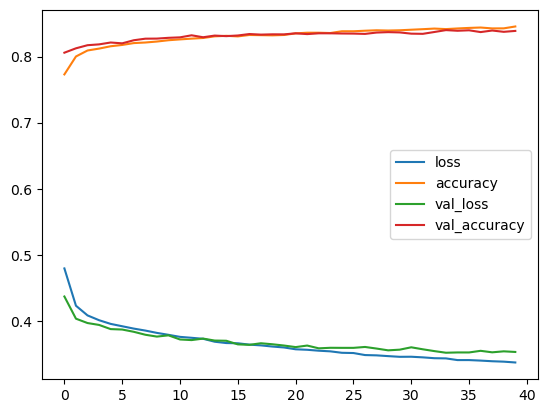

In [71]:
history_df2.plot()

<AxesSubplot:>

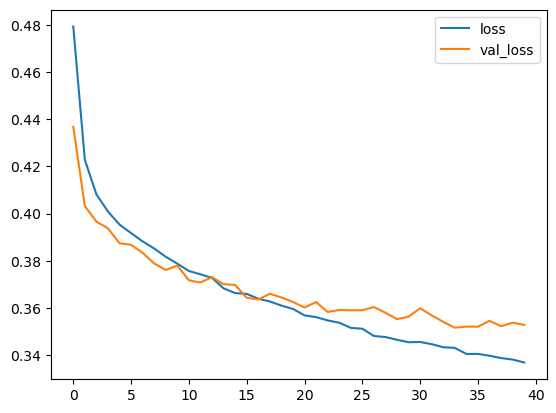

In [72]:
history_df2.loc[:, ['loss', 'val_loss']].plot()

## ajuste de hiperparámetros para el segundo modelo

In [73]:
import keras_tuner

In [91]:




def build_model(hp):
    model = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(hp.Choice('units1', [256, 512]),activation='relu'), #units1
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('rate1', [0.1, 0.3,0.5])),
        layers.Dense(hp.Choice('units2', [256, 512]),activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('rate2', [0.1, 0.3,0.5])),
        layers.Dense(1,activation='sigmoid'),
    ])
                     
    lr = hp.Choice("learning_rate",values=[1e-1, 1e-2, 1e-3])
    opt = keras.optimizers.Adam(learning_rate=lr)
    # compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy",
        metrics=["accuracy"])
                     
    return model
    
    






In [92]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)


In [93]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

best_model = tuner.get_best_models()[0]


Trial 5 Complete [00h 00m 57s]
val_loss: 1.3458166122436523

Best val_loss So Far: 0.39360228180885315
Total elapsed time: 00h 04m 33s
INFO:tensorflow:Oracle triggered exit


In [94]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
units1: 256
rate1: 0.1
units2: 512
rate2: 0.5
learning_rate: 0.001
Score: 0.39360228180885315


In [95]:

# rentreno con los mejkores hierparams

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hps)

final_history = final_model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
2799/2799 [==============================] - 13s 4ms/step - loss: 0.4544 - accuracy: 0.7896 - val_loss: 0.4163 - val_accuracy: 0.8037
Epoch 2/40
2799/2799 [==============================] - 12s 4ms/step - loss: 0.4174 - accuracy: 0.8057 - val_loss: 0.4007 - val_accuracy: 0.8156
Epoch 3/40
2799/2799 [==============================] - 12s 4ms/step - loss: 0.4088 - accuracy: 0.8098 - val_loss: 0.4097 - val_accuracy: 0.8113
Epoch 4/40
2799/2799 [==============================] - 11s 4ms/step - loss: 0.4019 - accuracy: 0.8140 - val_loss: 0.3950 - val_accuracy: 0.8209
Epoch 5/40
2799/2799 [==============================] - 11s 4ms/step - loss: 0.3953 - accuracy: 0.8170 - val_loss: 0.3912 - val_accuracy: 0.8221
Epoch 6/40
2799/2799 [==============================] - 11s 4ms/step - loss: 0.3925 - accuracy: 0.8169 - val_loss: 0.3968 - val_accuracy: 0.8201
Epoch 7/40
2799/2799 [==============================] - 11s 4ms/step - loss: 0.3893 - accuracy: 0.8203 - val_loss: 0.3924 - val_ac

In [96]:
final_model.evaluate(X_test,y_test)

933/933 [==============================] - 1s 1ms/step - loss: 0.5630 - accuracy: 0.8293


[0.5629878640174866, 0.8293352723121643]

<AxesSubplot:>

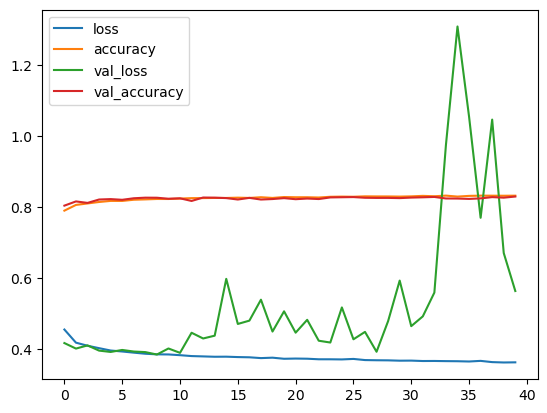

In [98]:
final_history_df = pd.DataFrame(final_history.history)


final_history_df.plot()

## <font color='blue'><b>Clasificación multiclase</b></font>